In [48]:
import pandas as pd
import numpy as np
import json
# 设置随机种子，保证结果的可重现性
np.random.seed(0)

# 生成1000行数据
data = {
    "温度": np.random.uniform(15, 30, 1000),  # 15到30摄氏度之间的随机数
    "湿度": np.random.uniform(30, 70, 1000),  # 30%到70%之间的随机数
    "光亮度": np.random.uniform(100, 800, 1000),  # 100到800流明之间的随机数
}

df = pd.DataFrame(data)

# 假设学习效率与环境的关系
# 简单的模拟学习效率基于环境变量的函数，这里只是为了演示
# 真实模型可能会更加复杂
def simulate_efficiency(temperature, humidity, brightness):
    # 规范化
    norm_temp = (temperature - 15) / (30 - 15)
    norm_humidity = (humidity - 30) / (70 - 30)
    norm_brightness = (brightness - 100) / (800 - 100)
    
    # 简单的假设：最佳学习效率在温度22度，湿度50%，光亮度450流明
    efficiency = 1 - (abs(norm_temp - 0.5) + abs(norm_humidity - 0.5) + abs(norm_brightness - 0.5)/3)
    return np.clip(efficiency, 0, 1)

# 计算每一行的学习效率
df['学习效率'] = df.apply(lambda row: simulate_efficiency(row['温度'], row['湿度'], row['光亮度']), axis=1)

# 显示前几行数据查看
print(df.head())
# 将DataFrame保存为CSV文件
df.to_csv('data/student_efficiency_environment.csv', index=False)

          温度         湿度         光亮度      学习效率
0  23.232203  53.715211  668.062929  0.754467
1  25.727840  30.402548  433.258790  0.286902
2  24.041451  49.033048  466.209193  0.865344
3  23.173248  58.350816  275.364410  0.663187
4  21.354822  31.759017  523.530112  0.432616


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error

图表已保存至: ./data/model_performance_plots.png


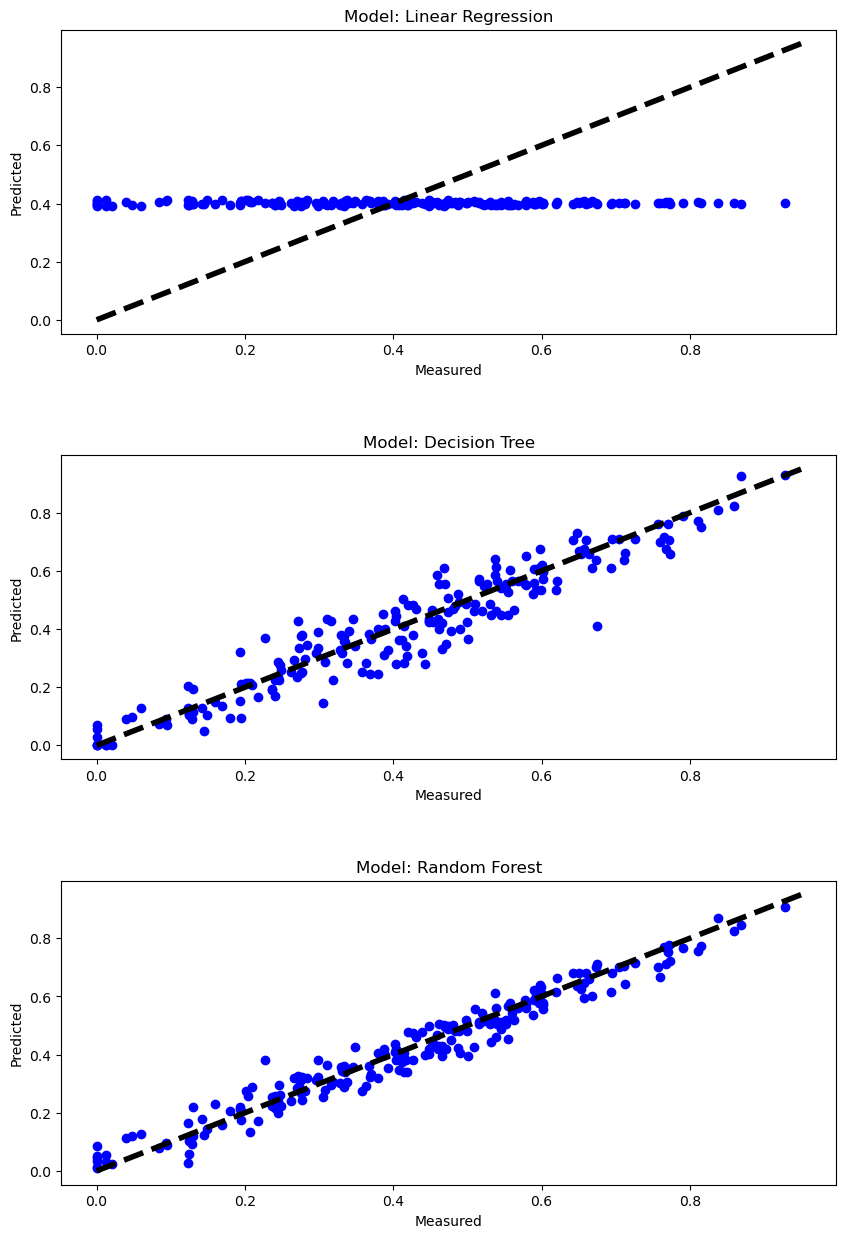

Model name：Linear Regression
MSE: 0.04360397782322452
MAE: 0.17134953738475503
---
Model name：Decision Tree
MSE: 0.004262899949860341
MAE: 0.05003503776344515
---
Model name：Random Forest
MSE: 0.001884417493886421
MAE: 0.035069754433084396
---
Best Model：Random Forest


In [58]:
# 定义X和y
X = df[["温度", "湿度", "光亮度"]]
y = df["学习效率"]
# 为了保存每个模型的性能指标
model_performance = {}
# 划分训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 模型字典
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=10)
}
# 绘图
fig, axs = plt.subplots(len(models), figsize=(10, 15))
fig.subplots_adjust(hspace=0.4)
for idx, (name, model) in enumerate(models.items()):
    # 模型训练
    model.fit(X_train, y_train)
    # 预测
    y_pred = model.predict(X_test)
    # 计算指标
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # 保存性能指标
    model_performance[name] = {'MSE': mse, 'MAE': mae}
    # 绘图
    axs[idx].scatter(y_test, y_pred, color='blue')
    axs[idx].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    axs[idx].set_title(f'Model: {name}')
    axs[idx].set_xlabel('Measured')
    axs[idx].set_ylabel('Predicted')
    # 保存图片到指定目录
save_path = './output/model_performance_plots.png'  # 请根据自己的文件系统修改此路径
plt.savefig(save_path)
print(f"图表已保存至: {save_path}")
plt.show()
best_model_name = None
best_model_metric = None
best_model_mse = np.inf
for model, performance in model_performance.items():
    print(f"Model name：{model}")
    if performance['MSE'] < best_model_mse:  # 寻找具有最大R^2值的模型
        best_model_name = model
        best_model_metric = performance
        best_model_mse = performance['MSE']
    for metric, value in performance.items(): 
        print(f"{metric}: {value}")
    print("---")
# 输出最佳模型名称和性能指标
print(f"Best Model：{best_model_name}")

# So the best model is random forest

In [ ]:
import os
import requests
import json 
import time
headers = {
    'Content-Type': 'application/json',
}
# 循环遍历每一行数据
for index, row in df.iterrows():
    # 取出对应列的数据
    temperature = round(float(row['温度']),2)
    humidity = round(float(row['湿度']),2)
    lightness = round(float(row['光亮度']),2)
    efficiency = round(float(row['学习效率'])*100,2)
    data_telemetry = {"temperature": temperature,"humidity": humidity,"lightness":lightness,"efficiency":efficiency}#initialization
    data_telemetry = json.dumps(data_telemetry)
    requests.post('https://thingsboard.cloud/api/v1/g1n3GkNyhZ90elvRRUkr/telemetry', headers=headers, data=data_telemetry)
    print(f"Temperature: {temperature}, Humidity: {humidity}, lightness: {lightness}, Efficiency: {efficiency}")
    time.sleep(5)#wait 5 seconds to sent the next data
    

Temperature: 23.23, Humidity: 53.72, lightness: 668.06, Efficiency: 75.45
Temperature: 25.73, Humidity: 30.4, lightness: 433.26, Efficiency: 28.69
Temperature: 24.04, Humidity: 49.03, lightness: 466.21, Efficiency: 86.53
Temperature: 23.17, Humidity: 58.35, lightness: 275.36, Efficiency: 66.32
Temperature: 21.35, Humidity: 31.76, lightness: 523.53, Efficiency: 43.26
Temperature: 24.69, Humidity: 65.18, lightness: 312.03, Efficiency: 40.89
Temperature: 21.56, Humidity: 50.8, lightness: 504.1, Efficiency: 89.17
Temperature: 28.38, Humidity: 31.23, lightness: 218.77, Efficiency: 2.88
Temperature: 29.45, Humidity: 38.98, lightness: 211.63, Efficiency: 14.72
Temperature: 20.75, Humidity: 68.15, lightness: 391.92, Efficiency: 40.21
Temperature: 26.88, Humidity: 53.29, lightness: 398.77, Efficiency: 60.16
Temperature: 22.93, Humidity: 34.3, lightness: 287.68, Efficiency: 50.13
Temperature: 23.52, Humidity: 41.5, lightness: 192.12, Efficiency: 59.67
Temperature: 28.88, Humidity: 48.27, lightne

Temperature: 25.49, Humidity: 44.31, lightness: 266.03, Efficiency: 57.07
Temperature: 19.46, Humidity: 36.55, lightness: 228.45, Efficiency: 35.56
Temperature: 27.21, Humidity: 47.65, lightness: 628.35, Efficiency: 54.26
Temperature: 20.95, Humidity: 40.51, lightness: 475.12, Efficiency: 64.73
Temperature: 28.22, Humidity: 50.88, lightness: 567.34, Efficiency: 54.1
Temperature: 23.72, Humidity: 31.41, lightness: 674.32, Efficiency: 34.71
Temperature: 28.23, Humidity: 66.25, lightness: 261.54, Efficiency: 12.23
Temperature: 25.39, Humidity: 62.65, lightness: 328.15, Efficiency: 43.31
Temperature: 25.88, Humidity: 52.1, lightness: 595.85, Efficiency: 65.27
Temperature: 22.52, Humidity: 64.07, lightness: 374.93, Efficiency: 61.11
Temperature: 29.34, Humidity: 68.5, lightness: 120.49, Efficiency: 0.0
Temperature: 24.66, Humidity: 34.42, lightness: 404.47, Efficiency: 44.49
Temperature: 21.36, Humidity: 55.23, lightness: 735.79, Efficiency: 65.69
Temperature: 24.1, Humidity: 69.92, lightne

Temperature: 17.78, Humidity: 67.53, lightness: 773.42, Efficiency: 9.34
Temperature: 29.29, Humidity: 39.78, lightness: 252.29, Efficiency: 19.76
Temperature: 25.31, Humidity: 48.33, lightness: 128.94, Efficiency: 61.78
Temperature: 18.23, Humidity: 60.3, lightness: 471.14, Efficiency: 44.8
Temperature: 29.21, Humidity: 38.14, lightness: 765.99, Efficiency: 10.58
Temperature: 25.96, Humidity: 52.65, lightness: 737.28, Efficiency: 56.6
Temperature: 18.81, Humidity: 37.43, lightness: 509.26, Efficiency: 41.15
Temperature: 18.2, Humidity: 34.19, lightness: 312.48, Efficiency: 25.26
Temperature: 22.77, Humidity: 34.66, lightness: 330.97, Efficiency: 54.17
Temperature: 15.38, Humidity: 44.31, lightness: 728.54, Efficiency: 25.07
Temperature: 18.11, Humidity: 30.19, lightness: 444.25, Efficiency: 20.94
Temperature: 21.37, Humidity: 46.99, lightness: 191.78, Efficiency: 72.66
Temperature: 20.61, Humidity: 56.57, lightness: 273.9, Efficiency: 62.61
Temperature: 21.95, Humidity: 46.07, lightne

Temperature: 18.89, Humidity: 60.73, lightness: 612.97, Efficiency: 41.36
Temperature: 20.61, Humidity: 51.11, lightness: 168.77, Efficiency: 71.22
Temperature: 23.81, Humidity: 39.5, lightness: 356.28, Efficiency: 60.53
Temperature: 19.09, Humidity: 40.85, lightness: 724.85, Efficiency: 41.32
Temperature: 20.56, Humidity: 40.32, lightness: 159.11, Efficiency: 49.04
Temperature: 17.96, Humidity: 51.29, lightness: 215.84, Efficiency: 55.32
Temperature: 21.9, Humidity: 58.13, lightness: 537.79, Efficiency: 71.49
Temperature: 15.67, Humidity: 67.97, lightness: 535.95, Efficiency: 5.44
Temperature: 27.0, Humidity: 57.76, lightness: 686.76, Efficiency: 39.34
Temperature: 16.15, Humidity: 61.25, lightness: 754.84, Efficiency: 15.06
Temperature: 22.78, Humidity: 36.76, lightness: 199.39, Efficiency: 53.08
Temperature: 19.6, Humidity: 44.96, lightness: 281.56, Efficiency: 60.07
Temperature: 23.66, Humidity: 46.55, lightness: 399.22, Efficiency: 81.21
Temperature: 29.39, Humidity: 57.46, lightn

Temperature: 29.53, Humidity: 54.61, lightness: 509.25, Efficiency: 38.75
Temperature: 28.57, Humidity: 61.7, lightness: 163.89, Efficiency: 16.63
Temperature: 19.45, Humidity: 63.43, lightness: 520.33, Efficiency: 42.74
Temperature: 29.88, Humidity: 49.34, lightness: 367.07, Efficiency: 45.2
Temperature: 18.74, Humidity: 65.25, lightness: 707.31, Efficiency: 24.57
Temperature: 16.59, Humidity: 66.66, lightness: 319.17, Efficiency: 12.72
Temperature: 29.26, Humidity: 40.86, lightness: 503.62, Efficiency: 29.51
Temperature: 18.5, Humidity: 54.3, lightness: 398.6, Efficiency: 60.14
Temperature: 25.35, Humidity: 51.06, lightness: 713.38, Efficiency: 65.82
Temperature: 15.88, Humidity: 51.52, lightness: 277.74, Efficiency: 43.84
Temperature: 25.96, Humidity: 67.51, lightness: 155.16, Efficiency: 19.12
Temperature: 28.23, Humidity: 42.21, lightness: 624.06, Efficiency: 34.06
Temperature: 19.09, Humidity: 69.34, lightness: 389.03, Efficiency: 26.0
Temperature: 20.69, Humidity: 66.09, lightne

Temperature: 24.28, Humidity: 55.62, lightness: 590.14, Efficiency: 67.39
Temperature: 17.0, Humidity: 57.55, lightness: 700.93, Efficiency: 32.53
Temperature: 29.71, Humidity: 31.7, lightness: 273.22, Efficiency: 0.0
Temperature: 28.08, Humidity: 50.58, lightness: 320.52, Efficiency: 55.21
Temperature: 22.54, Humidity: 51.87, lightness: 450.47, Efficiency: 95.02
Temperature: 28.84, Humidity: 43.6, lightness: 150.46, Efficiency: 27.51
Temperature: 23.12, Humidity: 32.74, lightness: 162.75, Efficiency: 39.04
Temperature: 28.85, Humidity: 39.16, lightness: 394.78, Efficiency: 27.93
Temperature: 27.45, Humidity: 44.32, lightness: 282.85, Efficiency: 44.85
Temperature: 29.52, Humidity: 47.41, lightness: 384.23, Efficiency: 43.55
Temperature: 28.8, Humidity: 53.64, lightness: 418.07, Efficiency: 47.41
Temperature: 15.54, Humidity: 58.9, lightness: 783.39, Efficiency: 15.49
Temperature: 17.62, Humidity: 42.71, lightness: 760.98, Efficiency: 34.43
Temperature: 20.84, Humidity: 43.16, lightnes

Temperature: 24.22, Humidity: 41.26, lightness: 413.51, Efficiency: 64.96
Temperature: 16.05, Humidity: 45.09, lightness: 776.35, Efficiency: 29.19
Temperature: 27.34, Humidity: 67.04, lightness: 655.12, Efficiency: 15.39
Temperature: 24.8, Humidity: 62.72, lightness: 678.5, Efficiency: 41.97
Temperature: 25.9, Humidity: 54.57, lightness: 767.74, Efficiency: 50.8
Temperature: 23.05, Humidity: 38.86, lightness: 372.2, Efficiency: 64.75
Temperature: 16.66, Humidity: 31.77, lightness: 506.06, Efficiency: 12.8
Temperature: 21.08, Humidity: 47.25, lightness: 585.51, Efficiency: 77.18
Temperature: 21.08, Humidity: 56.91, lightness: 571.42, Efficiency: 67.49
Temperature: 19.82, Humidity: 63.14, lightness: 767.06, Efficiency: 34.16
Temperature: 15.45, Humidity: 64.11, lightness: 301.84, Efficiency: 10.67
Temperature: 26.06, Humidity: 31.31, lightness: 303.95, Efficiency: 22.6
Temperature: 16.65, Humidity: 39.77, lightness: 742.6, Efficiency: 21.46
Temperature: 24.09, Humidity: 43.56, lightness